In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, least, greatest, when, udf, concat, lit
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import tomli
import json

In [22]:
spark = SparkSession.builder \
    .appName("PokerHandParser") \
    .master("local[*]") \
    .getOrCreate()

In [23]:
df_files = spark.read.json("parsed_dir")
df_files.show()

25/07/08 22:01:07 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


+--------+---------+----------------+----------------+-------+---------+-----------+-----------+---------+--------+
|card_gap|high_card|hole_card_1_rank|hole_card_2_rank|is_pair|is_suited|net_gain_bb|num_players|player_id|position|
+--------+---------+----------------+----------------+-------+---------+-----------+-----------+---------+--------+
|       1|       14|              13|              14|  false|    false|     -100.0|          6| Pluribus|       1|
|       3|       13|              10|              13|  false|    false|     -12.02|          6| MrOrange|       1|
|       1|       13|              12|              13|  false|    false|     -21.77|          6| MrOrange|       4|
|       2|       14|              12|              14|  false|    false|     -27.25|          6| MrBlonde|       0|
|       1|       14|              14|              13|  false|    false|     -100.0|          6| MrOrange|       1|
|       3|       13|              13|              10|  false|    false|

In [ ]:
# Step 1: Normalize ranks (regardless of card order)
df_normalized = df_files.withColumn("low_rank", least("hole_card_1_rank", "hole_card_2_rank")) \
                        .withColumn("high_rank", greatest("hole_card_1_rank", "hole_card_2_rank"))

# Step 2: Map numeric ranks to poker symbols (2–9, T, J, Q, K, A)
def rank_to_symbol(col_name):
    return when(col(col_name) == 14, "A") \
        .when(col(col_name) == 13, "K") \
        .when(col(col_name) == 12, "Q") \
        .when(col(col_name) == 11, "J") \
        .when(col(col_name) == 10, "T") \
        .otherwise(col(col_name).cast("string"))

# Step 3: Apply rank symbol conversion
df_mapped = df_normalized.withColumn("high_rank_str", rank_to_symbol("high_rank")) \
                         .withColumn("low_rank_str", rank_to_symbol("low_rank"))

# Step 4: Create hand label like "AKs" or "JTo"
df_labeled = df_mapped.withColumn(
    "hand_label",
    concat_ws(
        "",
        col("high_rank_str"),
        col("low_rank_str"),
        when(col("is_suited"), "s").otherwise("o")
    )
)

# Step 5: Group by hand_label and count
df_histogram = df_labeled.groupBy("hand_label").count().orderBy("count", ascending=False)

# Step 6: Convert to Pandas for plotting
hist_data = df_histogram.toPandas()

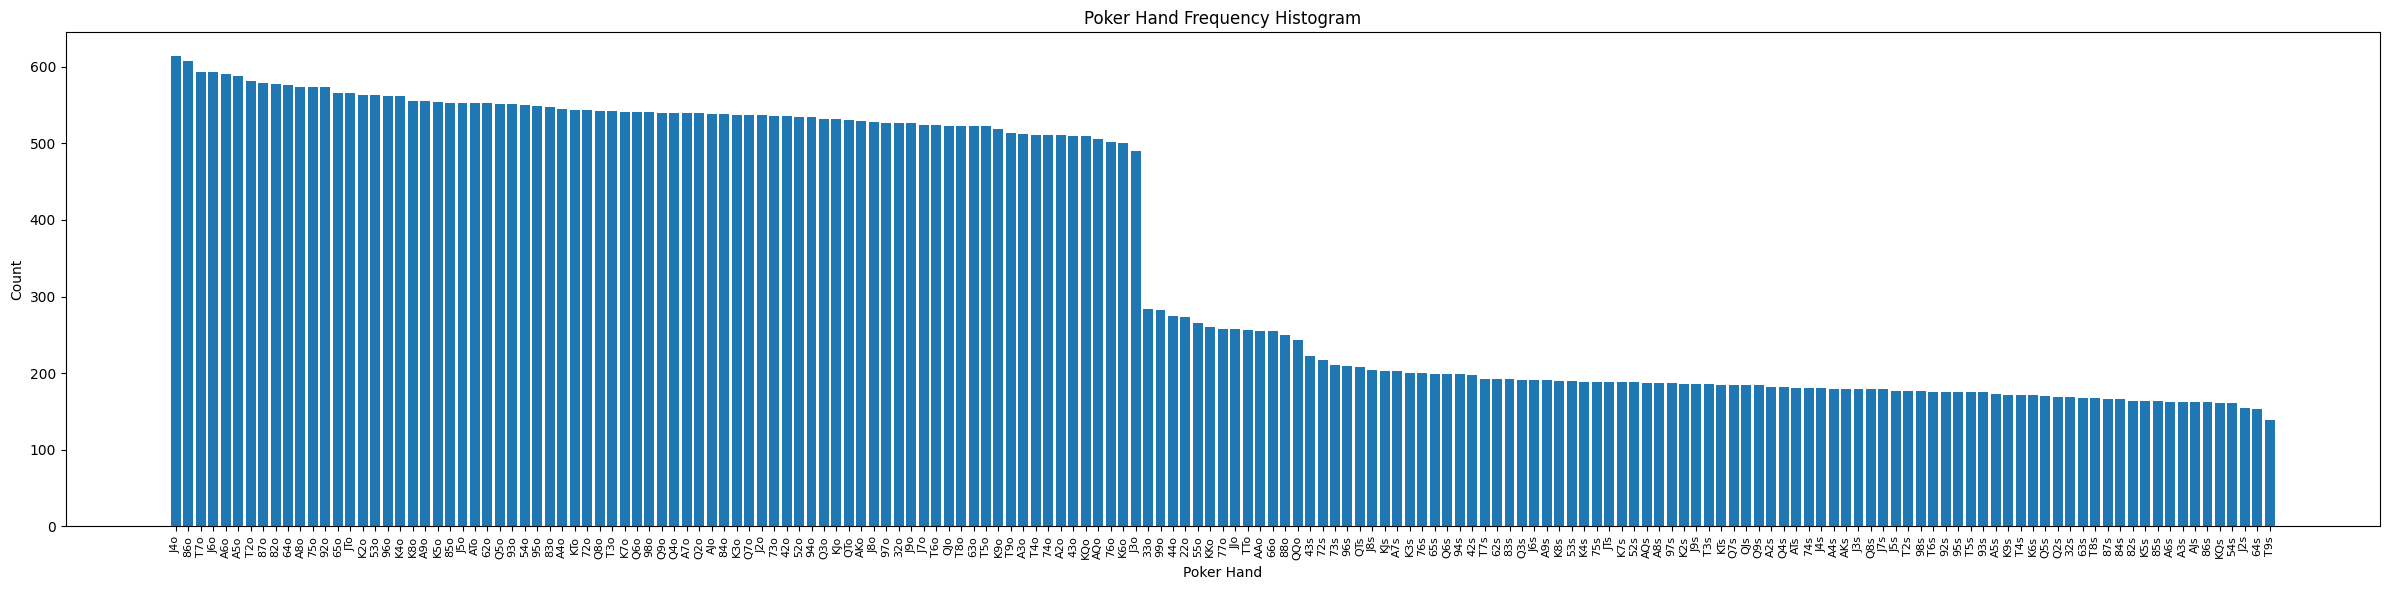

In [ ]:
# Plot clean histogram of Hand Frequency
plt.figure(figsize=(24, 6))
plt.bar(x=hist_data['hand_label'], height=hist_data['count'])

plt.xlabel('Poker Hand')
plt.ylabel('Count')
plt.title('Poker Hand Frequency Histogram')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [8]:
# Heatmap hand occurences

# Convert Spark DF to Pandas
hist_data = df_histogram.toPandas()

# Define poker ranks in descending order (used for both rows and columns)
ranks = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']

# Create a 13x13 DataFrame filled with NaNs
grid = pd.DataFrame(np.nan, index=ranks, columns=ranks)


# Fill the grid
for _, row in hist_data.iterrows():
    label = row['hand_label']
    count = row['count']
    
    rank1 = label[0]
    rank2 = label[1]
    suitedness = label[2]
    
    if suitedness == 's':
        grid.loc[rank1, rank2] = count  # upper triangle
    elif suitedness == 'o':
        grid.loc[rank2, rank1] = count  # lower triangle
    else:  # fallback for pairs like "AA"
        grid.loc[rank1, rank2] = count


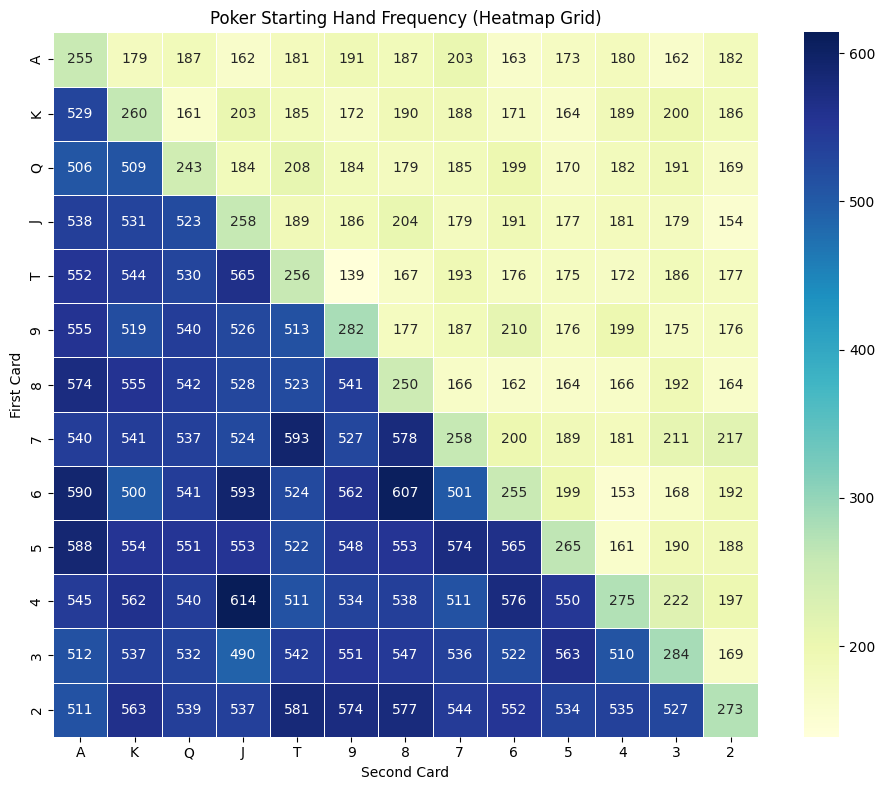

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(grid, cmap="YlGnBu", annot=True, fmt=".0f", cbar=True, linewidths=0.5, square=True)

plt.title("Poker Starting Hand Frequency (Heatmap Grid)")
plt.xlabel("Second Card")
plt.ylabel("First Card")
plt.tight_layout()
plt.show()


In [21]:
df_position_wins_pd.head(10)

,position,total_net_win
0,0,-1941.725
1,5,1098.720
2,1,-4380.445
3,3,591.430
4,2,2186.770
5,4,2445.250


In [27]:
# Map numeric positions to labels
position_map = {
    0: "SB",   
    1: "BB",   
    2: "UTG",
    3: "HJ",
    4: "CO",
    5: "BTN"
}

# Group by numeric position and sum net win
df_position_wins = df_files.groupBy("position").sum("net_gain_bb").withColumnRenamed("sum(net_gain_bb)", "total_net_win")

# Convert to Pandas
df_position_wins_pd = df_position_wins.toPandas()

# Map numeric positions to labels
df_position_wins_pd['position_label'] = df_position_wins_pd['position'].map(position_map)

# Define desired order for display
position_order = ['UTG', 'HJ', 'CO', 'BTN', 'SB', 'BB']

# Convert to categorical for proper sorting
df_position_wins_pd['position_label'] = pd.Categorical(
    df_position_wins_pd['position_label'],
    categories=position_order,
    ordered=True
)

# Sort
df_position_wins_pd = df_position_wins_pd.sort_values('position_label')


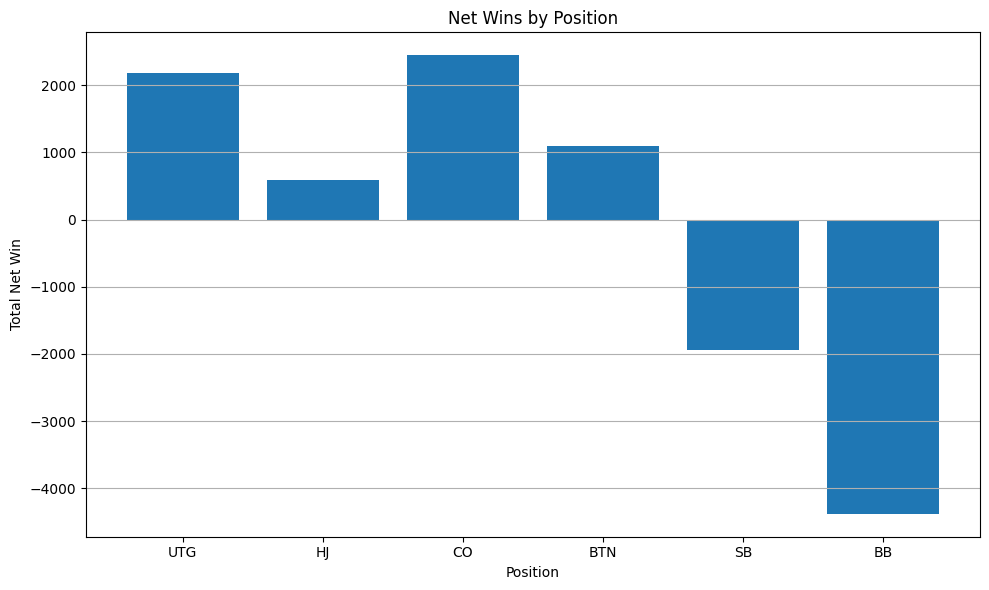

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(df_position_wins_pd['position_label'], df_position_wins_pd['total_net_win'])

plt.xlabel("Position")
plt.ylabel("Total Net Win")
plt.title("Net Wins by Position")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [31]:
df_player_wins = df_files.groupBy("player_id").sum("net_gain_bb") \
                         .withColumnRenamed("sum(net_gain_bb)", "total_net_win")
df_player_wins_pd = df_player_wins.toPandas()
df_player_wins_pd = df_player_wins_pd.sort_values("total_net_win", ascending=False)


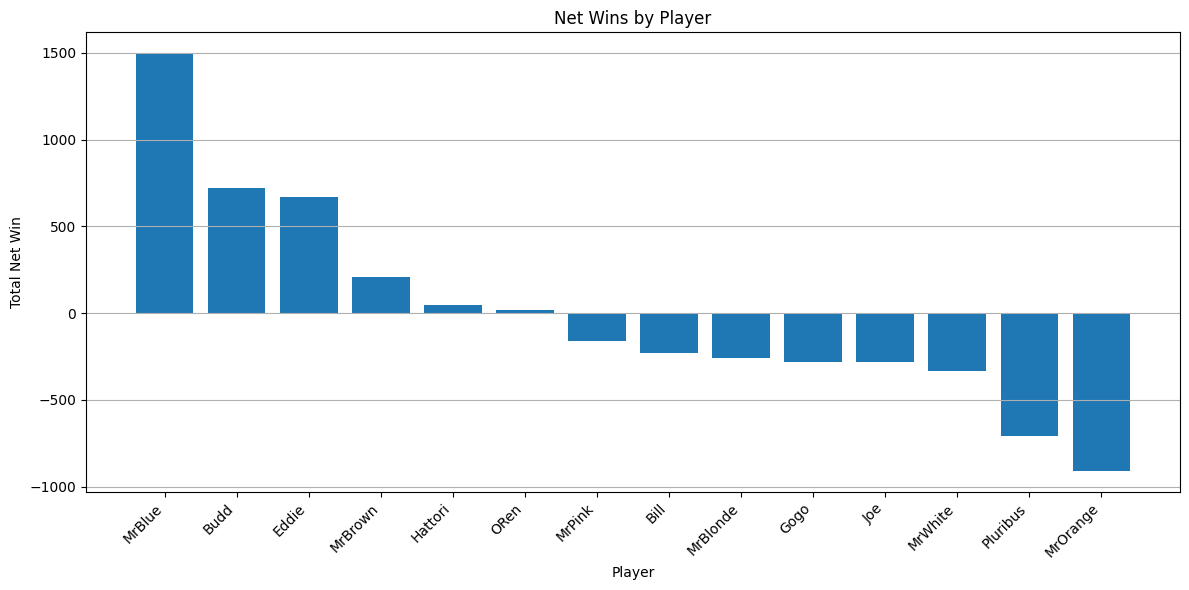

In [33]:
plt.figure(figsize=(12, 6))
plt.bar(df_player_wins_pd['player_id'], df_player_wins_pd['total_net_win'])

plt.xlabel("Player")
plt.ylabel("Total Net Win")
plt.title("Net Wins by Player")
plt.xticks(rotation=45, ha='right')  # rotate for readability
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [44]:
# Step 1: Sort the cards (low/high doesn't matter for suitedness)
df = df_files.withColumn("low_card", least("hole_card_1_rank", "hole_card_2_rank")) \
       .withColumn("high_card", greatest("hole_card_1_rank", "hole_card_2_rank"))

# Step 2: Map numbers to rank symbols (2–14 → '2'–'A')
rank_map = {
    14: "A", 13: "K", 12: "Q", 11: "J", 10: "T",
     9: "9",  8: "8",  7: "7",  6: "6",  5: "5",
     4: "4",  3: "3",  2: "2"
}

@udf(returnType=StringType())
def to_rank_symbol(rank):
    return rank_map.get(rank, str(rank))

df = df.withColumn("low_symbol", to_rank_symbol(col("low_card"))) \
       .withColumn("high_symbol", to_rank_symbol(col("high_card")))

# Step 3: Create hand label (e.g., 'AKs' or 'T9o')
df = df.withColumn(
    "hand_label",
    concat(
        col("high_symbol"),
        col("low_symbol"),
        when(col("is_suited") == True, lit("s")).otherwise(lit("o"))
    )
)

df_hand_avg = df.groupBy("hand_label").avg("net_gain_bb") \
                .withColumnRenamed("avg(net_gain_bb)", "avg_net_gain_bb")

df_hand_avg_pd = df_hand_avg.toPandas().sort_values("avg_net_gain_bb", ascending=False)

# Poker ranks from strongest to weakest
ranks = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']

# Create an empty grid (NaNs)
heatmap_data = pd.DataFrame(np.nan, index=ranks, columns=ranks)

for _, row in df_hand_avg_pd.iterrows():
    label = row["hand_label"]
    value = row["avg_net_gain_bb"]

    if len(label) == 3:  # e.g. AKs, JTo
        r1, r2, suitedness = label[0], label[1], label[2]
        
        if suitedness == 's':
            heatmap_data.loc[r1, r2] = value  # upper triangle
        elif suitedness == 'o':
            heatmap_data.loc[r2, r1] = value  # lower triangle
    elif len(label) == 2:  # e.g. AA
        r = label[0]
        heatmap_data.loc[r, r] = value

for _, row in df_hand_avg_pd.iterrows():
    label = row["hand_label"]
    value = row["avg_net_gain_bb"]

    if len(label) == 3:  # e.g. AKs, JTo
        r1, r2, suitedness = label[0], label[1], label[2]
        
        if suitedness == 's':
            heatmap_data.loc[r1, r2] = value  # upper triangle
        elif suitedness == 'o':
            heatmap_data.loc[r2, r1] = value  # lower triangle
    elif len(label) == 2:  # e.g. AA
        r = label[0]
        heatmap_data.loc[r, r] = value


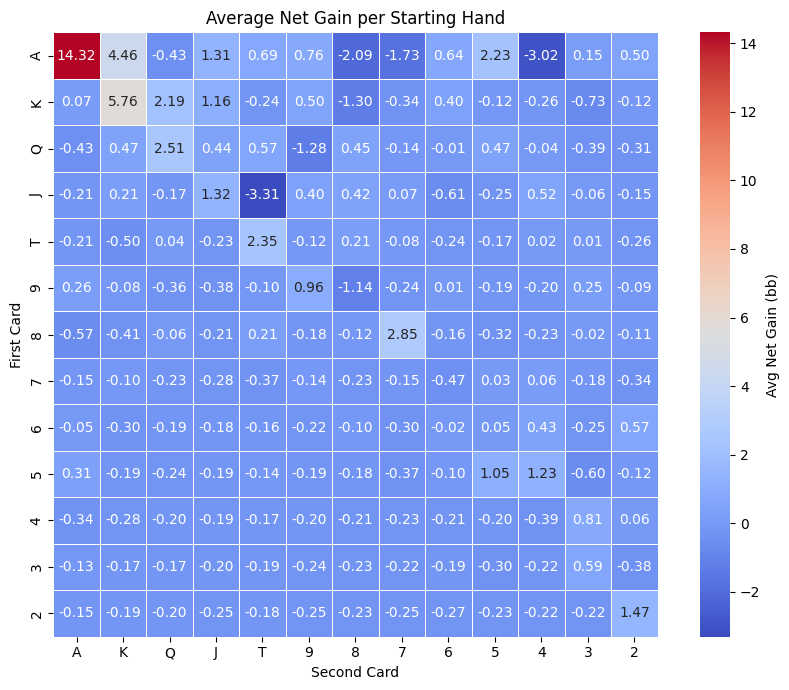

In [46]:
plt.figure(figsize=(9, 7))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f", square=True,
            linewidths=0.5, cbar_kws={'label': 'Avg Net Gain (bb)'})

plt.title("Average Net Gain per Starting Hand")
plt.xlabel("Second Card")
plt.ylabel("First Card")
plt.tight_layout()
plt.show()